# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable??


## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

The main goal of the present challenge was to understand the senior citizens' mobility patterns, their characteristics and possible improvement points. For this reason, we first tried to understand the primary pain points that the Portugals' elder citizen feels when using the available public transportation, so we could better focus on possible improvements that could lead to a better quality of life.

In the first iteration, we analyzed the senior mobility characterization by Municipality to better understand their patterns, how it varies considering the percentage of the ageing population in the given locations.
After having a better sense of the data, our team brainstormed on possible improvement points, which lead us to think about several options.  Nonetheless, for our team, the distance between the public transports stops and the elders' points of interest is the most important point to be solved. Not everyone has the physical capacity to arrive at their destiny, especially if it means walking a significant distance between the bus stop and a health facility.

For this reason, our team focused on analyzing the distances between the public transportation stops and the seniors' citizens points of interest to better provide bus stops/lines recommendations.

## Development
Start coding here! 🐱‍🏍

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

# Install packages

In [ ]:
! pip install geopandas
! pip install osmium
! pip install geopy

# Import packages

In [ ]:
import pandas as pd
import geopandas as gpd
import osmium
import json
import numpy as np
from geopy import distance

# 1. Understanding Senior citizens public transportation behaviour by Municipality

## 1.1 Data imports from WDL datasets

In [ ]:
bus_routes_path = 'https://wdl-data.fra1.digitaloceanspaces.com/pse/BusRoutes.txt'
seniors_tim_path = 'https://wdl-data.fra1.digitaloceanspaces.com/pse/Senior_TIM_v1.txt'
churn_path = 'https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_UsersProfile.txt'

bus_routes = pd.read_csv(bus_routes_path, delimiter = "|")
seniors_tim = pd.read_csv(seniors_tim_path, delimiter="|", encoding = "latin")
Churn_UsersProfile = pd.read_csv(churn_path, delimiter="|", encoding = "latin")

## 1.2 Prepare the data

In [ ]:
# Merge Seniors tim data with Bus routes data
seniors_tim = seniors_tim.merge(
    right = bus_routes,
    how = 'left',
    on = 'linkid'
)

For this analysis, we focused on the pre-pandemic data since the elderly population was one of the most affected age group during this time. If we considered this time during the analysis, we would be considering external patterns rather than simply focusing on senior mobility since there were guidelines and mobility restrictions during the pandemic, leading to a decrease in the public transportation demand.


In [ ]:
# Select data before the pandemic
Churn_UsersProfile = Churn_UsersProfile[Churn_UsersProfile['Period'] == 'Sep-19 to Feb-20']

# Group by to create the total population average daily users
Churn_UsersProfile_total_users = Churn_UsersProfile.groupby(['Region_of_Origin', 'District_of_Origin', 'County_of_Origin', 'Period'], dropna = False).sum().reset_index()
Churn_UsersProfile_total_users.rename(columns={'Average_BusUsers_per_Day':'Average_BusUsers_per_Day_all_ages'}, inplace=True)

# Create a senior users profile
Churn_UsersProfile_seniors_only = Churn_UsersProfile[Churn_UsersProfile['AgeClassDescription'] == '65+']
Churn_UsersProfile_seniors_only = Churn_UsersProfile_seniors_only.groupby(['Region_of_Origin', 'District_of_Origin', 'County_of_Origin', 'Period'], dropna = False).sum().reset_index()
Churn_UsersProfile_seniors_only.rename(columns={'Average_BusUsers_per_Day':'Average_BusUsers_per_Day_seniors'}, inplace=True)

In [ ]:
# Obtain rate of public transport usage by Seniors in the entiry  population of Bus users 
Churn_UsersProfile_seniors_only = Churn_UsersProfile_seniors_only.merge(
    right = Churn_UsersProfile_total_users,
    how = 'left', 
    on = ['Region_of_Origin', 'District_of_Origin', 'County_of_Origin', 'Period']
)

Churn_UsersProfile_seniors_only['seniors_ratio'] = Churn_UsersProfile_seniors_only['Average_BusUsers_per_Day_seniors'] / Churn_UsersProfile_seniors_only['Average_BusUsers_per_Day_all_ages']

In [ ]:
# Retrieved data from https://www.pordata.pt/Municipios/População+residente+total+e+por+grandes+grupos+etários-390 and cleaned the fields
path_pop_muncipios = 'https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/pop_municipios.csv'
pop_municipios = pd.read_csv(path_pop_muncipios, encoding = 'latin-1')
pop_municipios.columns = ['Municipio', 'pop_total', 'pop_idosa', 'racio_pop_idosa']
pop_municipios.head()

,Municipio,pop_total,pop_idosa,racio_pop_idosa
0,Alcoutim,2917,1282,0.439493
1,Penamacor,5682,2481,0.436642
2,Vila Velha de Ródão,3521,1535,0.435956
3,Idanha-a-Nova,9716,4169,0.429086
4,Pampilhosa da Serra,4481,1893,0.422450


In [ ]:
# Merge data by municipality
Churn_UsersProfile_seniors_only = Churn_UsersProfile_seniors_only.merge(
    right = pop_municipios,
    how = 'left',
    left_on = 'County_of_Origin',
    right_on = 'Municipio'
    )

Churn_UsersProfile_seniors_only = Churn_UsersProfile_seniors_only.drop(['Region_of_Origin', 'Municipio'], axis = 1)

In [ ]:
Churn_UsersProfile_seniors_only.head()

,District_of_Origin,County_of_Origin,Period,Average_BusUsers_per_Day_seniors,Average_BusUsers_per_Day_all_ages,seniors_ratio,pop_total,pop_idosa,racio_pop_idosa
0,Lisboa,Amadora,Sep-19 to Feb-20,1612.851365,8474.874368,0.190310,175136,32742,0.186952
1,Lisboa,Cascais,Sep-19 to Feb-20,2017.333975,13023.810109,0.154896,206479,36714,0.177810
2,Lisboa,Lisboa,Sep-19 to Feb-20,9072.259102,27874.289765,0.325471,547733,130960,0.239095
3,Lisboa,Loures,Sep-19 to Feb-20,147.474840,8483.736827,0.017383,205054,35277,0.172038
4,Lisboa,Mafra,Sep-19 to Feb-20,1217.088440,4601.247092,0.264513,76685,11344,0.147930


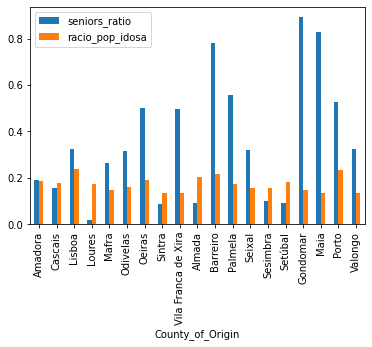

In [ ]:
Churn_UsersProfile_seniors_only.plot(x="County_of_Origin", y=["seniors_ratio", "racio_pop_idosa"], kind="bar")

As it is possible to state from the graph above, the seniors' ratio from the public transportation dataset in most cases is higher than the ratio of the elderly population according to the 2019 information extracted from PORDATA. Given this, it is possible to state that elderly people are avid users of public transportation when considering the entire population of public transportation users.

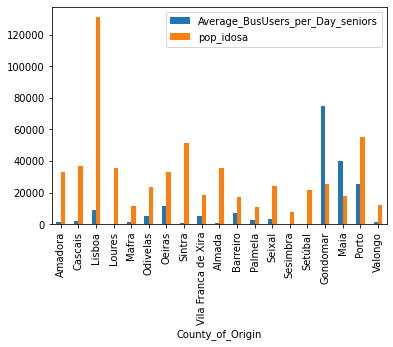

In [ ]:
Churn_UsersProfile_seniors_only.plot(x="County_of_Origin", y=["Average_BusUsers_per_Day_seniors", "pop_idosa"], kind="bar")

When comparing the average daily senior user of public transportation with the total value of the elderly population, it is possible to state that only in rare exceptions is a small percentage of seniors who really use public transportations. 

However, Gondomar and Maia present a curious pattern since the average daily users are higher than the total number of the senior population. This could indicate that in those municipalities, the elderly population resort to the usage of public transportation in a more avid manner.


# 2. Distance from Bus Stops to Health Centers

The first step was to gather the bus stops and Health Centers' data (longitude, latitude) to accomplish this task.

## 2.1 Openstreetmap Bus stops data

In [ ]:
# Get data from the metropolitan Porto area from bbbike
# Then Convert data to gpkg to read with geopandas

%%bash
wget https://download.bbbike.org/osm/bbbike/Porto/Porto.osm.pbf \
    --quiet -O Porto.osm.pbf

ogr2ogr \
  -f GPKG Porto.gpkg \
  Porto.osm.pbf

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
# Check if data is good
! ogrinfo Porto.osm.pbf

Had to open data source read-only.
INFO: Open of `Porto.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [ ]:
# Open with geopandas
gdf = gpd.read_file("Porto.gpkg", driver='GPKG')
gdf.head(2), gdf.shape

(     osm_id  ...                   geometry
 0  25264014  ...  POINT (-8.48964 40.90208)
 1  25264018  ...  POINT (-8.54267 40.92542)
 
 [2 rows x 11 columns], (76870, 11))

In [ ]:
# Select only bus stops data (highway == bus_stop)
busstop_df = gdf[gdf['highway'] == 'bus_stop'].copy()
busstop_df.shape

(3072, 11)

In [ ]:
# Format the longitude and latitude data to plot in a future step
busstop_df['longitude'] = busstop_df['geometry'].apply(lambda x: str(x).split(' ')[1].replace('(', ''))
busstop_df['latitude'] = busstop_df['geometry'].apply(lambda x: str(x).split(' ')[2].replace(')', ''))

# Create DataFrame with only the coordinates data
busstop_osm = busstop_df[['name', 'latitude', 'longitude']].copy()
busstop_osm.to_csv('bus_stops_osm.csv', index=False) # Please note this file is used in an external visualization (https://kepler.gl/demo) tool and not in this notebook.
busstop_osm.head(), busstop_osm.shape

(                        name    latitude           longitude
 461                     None  41.3533359          -8.4497292
 1166                    None  40.9818319  -8.615623100000001
 1300  Casa da Música (Metro)  41.1613174          -8.6297087
 1342                    None   41.358168  -8.365672400000001
 1402        Segurança Social  41.1571968          -8.6671829, (3072, 3))

## 2.2 STCP Bus stops data from porto digital

We found an external dataset containing the data for the STCP bus stops provided by Porto Digital (source: https://opendata.urbanplatform.portodigital.pt/ne/dataset/stcp-autocarros-paragens-centroides).
We then performed 3 queries to extract the bus stop data from this platform, the resulting files from those queries can be found in the following links.

In [ ]:
# External data from Porto Digital
%%bash

wget https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/portodigital_busstops_01.json \
    --quiet -O portodigital_busstops_01.json
wget https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/portodigital_busstops_02.json \
    --quiet -O portodigital_busstops_02.json
wget https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/portodigital_busstops_03.json \
    --quiet -O portodigital_busstops_03.json

In [ ]:
def parse_json(in_file):
  """
  Functionality:
    Process geo json file to create a DataFrame
  Input:
    Geo jason file
  Output:
    Pandas DataFrame
  """
  bus_stops = {"name":[], "latitude":[], "longitude":[]}

  with open(in_file) as json_file:
      data = json.load(json_file)
      for bus_stop in data["features"]:
        bus_stops["name"].append(bus_stop['properties']['codigo'])
        bus_stops["latitude"].append(bus_stop['geometry']['coordinates'][1])
        bus_stops["longitude"].append(bus_stop['geometry']['coordinates'][0])
  
  df = pd.DataFrame(bus_stops)
  df['cords'] = [tuple(_) for _ in df[['latitude', 'longitude']].values]
  return df

In [ ]:
# Concatenate the results from the 3 queries in one unique DataFrame
bus_stops_df = pd.concat([parse_json('portodigital_busstops_01.json'), 
                          parse_json('portodigital_busstops_02.json'),
                          parse_json('portodigital_busstops_03.json')], axis=0)

bus_stops_df.head(), bus_stops_df.shape

(    name   latitude  longitude                                    cords
 0      .  41.254128  -8.653737  (41.25412841245856, -8.653736724768118)
 1   1AAC  41.238812  -8.612783  (41.23881184687845, -8.612782565788029)
 2   1ADN  41.229745  -8.527130   (41.2297452008147, -8.527129521197322)
 3  1ANC1  41.238325  -8.615394  (41.23832484017553, -8.615393874671113)
 4  1ANC2  41.238297  -8.615224   (41.23829676930887, -8.61522377964076),
 (2519, 4))

In [ ]:
bus_stops_df[['name', 'latitude', 'longitude']].to_csv('bus_stops_portodigital.csv', index=False) # Please note this file is used in an external visualization (https://kepler.gl/demo) tool and not in this notebook.

## 2.3 Compare the bus stops data from the two different souces

To visually compare the points obtained for Bus stops using the Porto digital data and the OpenStreetMap, we used https://kepler.gl/demo. This web app allows the plotting of geographic locations using their latitude and longitude.

The following image demonstrates the difference in the bus stops locations obtained using Porto Digital data (green) and OpenStreetMap data (red).

![image](https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/image2.png)

As it is evident from the previous image, the concordance between the two datasets is not perfect. Some of it was expected since Porto Digital data only contained STCP (one bus company) data while Openstreetmap did not have that restriction. The most obvious solution for this was to aggregate the two datasets. However, this would generate data repetition, and since the data points are not perfectly on top of each other, deleting possible duplicates would be a challenging task. Therefore we decided to evaluate these two data sources, comparing them with a third visually (google maps).

![image](https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/image1.png)

As it is possible to see from the previous image, several points indicated be Openstreetmap (red boxes, panel A and C) that are not present in the other dataset or the google maps visualization (panel B and D). This uncertainty led us to feel unease about the OpenStreetMap data for the bus stops. Therefore, we decided to progress this work only using the Porto Digital data for the bus stops.

## 2.4 Healthcare centers data

These 41 data points were obtained manually (latitude and longitude), ensuring that all the Healthcare Centers in Porto Oriental and Occidental (as described by official sources: http://www.arsnorte.min-saude.pt/agrupamentos-de-centros-de-saude/aces-grande-porto-vi-porto-oriental/) were present.

In [ ]:
url_health_centers = 'https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/health_centers_porto.csv'
health_centers_df = pd.read_csv(url_health_centers)
health_centers_df.head(), health_centers_df.shape

(                     Name  longitude   latitude
 0      SAP Porto Oriental  -8.681758  41.160224
 1            UCC Campanhã  -8.567661  41.151552
 2            UCC Paranhos  -8.620631  41.156422
 3   UCSP Azevedo Campanhã  -8.567708  41.151483
 4  UCSP São Roque Lameira  -8.589250  41.157136, (41, 3))

## 2.5 Distance calculations

Iterate over all 41 Health center, and the 2519 bus stops used to find the minimal distance between every center and a bus stop (closest bus stop).

In [ ]:
health_centers_df['min_dist'] = 99999
health_centers_df["stop_name"] = ''
health_centers_df["colossets_stop_long"] = 0
health_centers_df["colossets_stop_lat"] = 0

for healthcenter in health_centers_df.iterrows():
  coords_healthcenter = (healthcenter[1]['latitude'], healthcenter[1]['longitude'])

  for busstop in bus_stops_df.iterrows():
    coords_busstop = ( busstop[1]['latitude'],busstop[1]['longitude'])
    new_distance = distance.vincenty(coords_healthcenter, coords_busstop).km*1000

    if new_distance < health_centers_df.loc[healthcenter[0], 'min_dist']:
      health_centers_df.loc[healthcenter[0], 'min_dist'] = new_distance
      health_centers_df.loc[healthcenter[0], 'stop_name'] = busstop[1]['name']
      health_centers_df.loc[healthcenter[0], 'colossets_stop_long'] = busstop[1]['longitude']
      health_centers_df.loc[healthcenter[0], 'colossets_stop_lat'] = busstop[1]['latitude']

With this, we can now observe the Healthcare centers further away from a bus stop. Being the top 5 most distant:

In [ ]:
health_centers_df.sort_values(by='min_dist', ascending=False)[['Name', 'min_dist']].head(n=3)

,Name,min_dist
9,USF Barão de Nova Sintra,202.560006
14,USF Aníbal Cunha,155.344922
12,USF Aldoar,133.460838


![image](https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/image3.png)

The three Healthcare centers with the longest distance to a bus stop were plotted in the previous image. In panel A there is the "USF Barão de Nova Sintra'' with the closest bus stop at more than 200 meters. Nevertheless, there is also a metro station nearby. The second case, in panel B, shows a similar case with the closest bus stop at more than 155 meters and others even further away. In the first example, panels C and D, we have an interesting case. Although our algorithm successfully identified the bus stop with the smaller walking distance, there is a second stop a bit further away but with a connection to one of the city's main arteries. To go from this point of interest to this second bus stop, a poorly characterized path needs to be taken. This is not even recognized by commonly used tools. This example highlights the need to better describe paths that may help citizens with mobility issues.

## 2.5 Grid search

Knowing about the worst served health center is excellent, but if we know all the points of interest where the elderly like to / have to go, we can suggest a new bus stop that lowers the total travelling distance. We use the code we used previously to calculate the worst served Points of interest (PoI) and run this for each of the possible buses stops on a grid to suggest a new bus stop. The selected bus stop is the one that has the best impact on lowering the total minimum distance from each PoI to a bus stop. If we had different PoI, not only health care centers, we could add weights to the calculus of the sum of distances. Assuming elderly people would prefer to have a bus stop closest to a health center than a commercial building, we would give a weight of 1 to the health center and a lower value to the commercial building.

In [ ]:
# Define costume box for the bus stop grid search
minLat = 41.1486
maxLat = 41.1586
minLon = -8.6236
maxLon = -8.6180

# Create the grid with about 40 meters between each point
latValuesToTest = np.arange(minLat,maxLat,0.0005)
lonValuesToTest = np.arange(minLon,maxLon,0.0005)
myNewBusStopPossibilities = []
for latValues in latValuesToTest:
  for lonValues in lonValuesToTest:
    myNewBusStopPossibilities.append((latValues, lonValues))

In [ ]:
dfTentativeBusStop = pd.DataFrame(myNewBusStopPossibilities)
dfTentativeBusStop["Name"] = ["TestPoint" + str(x) for x in range(len(dfTentativeBusStop))]
dfTentativeBusStop.columns = [ 'latitude', 'longitude', 'Name']
dfTentativeBusStop.head()

,latitude,longitude,Name
0,41.1486,-8.6236,TestPoint0
1,41.1486,-8.6231,TestPoint1
2,41.1486,-8.6226,TestPoint2
3,41.1486,-8.6221,TestPoint3
4,41.1486,-8.6216,TestPoint4


In [ ]:
baseline = sum(health_centers_df['min_dist'])
glob_min = baseline
best_new_stop = []
best_df = health_centers_df.copy()

i=0
for new_stop in dfTentativeBusStop.iterrows():
  i +=1
  myNewStops = bus_stops_df.append({'name': new_stop[1][2], "latitude": new_stop[1][0], "longitude": new_stop[1][1], "cords":(new_stop[1][0], new_stop[1][1])}, ignore_index=True)

  health_centers_df['min_dist'] = 99999
  health_centers_df["stop_name"] = ''
  health_centers_df["colossets_stop_long"] = 0
  health_centers_df["colossets_stop_lat"] = 0

  for healthcenter in health_centers_df.iterrows():

    coords_healthcenter = (healthcenter[1]['latitude'], healthcenter[1]['longitude'])

    for busstop in myNewStops.iterrows():
      coords_busstop = ( busstop[1]['latitude'],busstop[1]['longitude'])
      new_distance = distance.vincenty(coords_healthcenter, coords_busstop).km*1000

      if new_distance < health_centers_df.loc[healthcenter[0], 'min_dist']:
        health_centers_df.loc[healthcenter[0], 'min_dist'] = new_distance
        health_centers_df.loc[healthcenter[0], 'stop_name'] = busstop[1]['name']
        health_centers_df.loc[healthcenter[0], 'colossets_stop_long'] = busstop[1]['longitude']
        health_centers_df.loc[healthcenter[0], 'colossets_stop_lat'] = busstop[1]['latitude']

  print(str(i) + '/' + str(len(dfTentativeBusStop)))

  new_min =  sum(health_centers_df['min_dist'])
  if new_min < glob_min:
    glob_min = new_min
    best_new_stop = new_stop[1]
    best_df = health_centers_df.copy()

    print("New Minimum")
    print(new_min)
    print('New stop')
    print(best_new_stop)


![image](https://raw.githubusercontent.com/PMMAraujo/Control_Group_WDL/main/image4.png)

As you can see in the image above our grid search approach can find useful bus stops, that decreases the walking time to Healthcare centers. In the eventual case of looking to improve the bus stop network approaches like this can be used. This dummy example, for a small region of the Porto metro area, has several limitations but highlights the possibilities that data centred solutions have.

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

With our solution, the city can quickly improve the public transportation system by adapting them to the population needs. Having an automatic and intelligent manner of better planning and understanding our population needs can help the city council to create a better public transportation system or modify them according to their citizens. Sometimes we see bus stops being kept because it was near old points of interests, but the city would probably gain if the route was optimized with new information. Nonetheless, we are aware that creating or removing bus stops can be expensive, but having optimized routes could also bring new possible customers that would ultimately lead to increased transportation usage, resulting in a higher monetary return.

In terms of life quality, by providing a better transportation system, we would improve the senior population quality of life, since they would be able to easily go to their points of interests without depending on the help of external persons.

Finally, regarding the scalability of the solution, it is possible to expand this to other cities and points of interests. We would need to complete our data with those coordinates and information.

Nevertheless, we know that the presented solution has some flaws and limitations that could be fixed to create a more robust solution, such as:
* When performing the space search, we should only consider the bus stops within the street range since we could not exclude the stops on top of buildings. For that, we needed to create a human in the loop component.
* Use Googles' API to collect the walk distance between two points. We tried to obtain this information by using the OpenStreetMap framework, but we could only manage the car distances, which led to errors in some bus stops. For instance, instead of calculating a distance of 70m, we obtained 1300m because of the street orientation.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

Several additional pieces of information could help us improve our analysis and the social impact of our solution. Nonetheless, the information that we missed the most was:


*  Complete route information of the public transports. With this information, we could easily find the most impactful point of interests for the population. Or at least have enough data points so we could easily extrapolate the route path.

* The ability to connect the datasets from both challenges, so it was possible to better understand how COVID affected the population.

* Datasets with weighted Points of Interests so it was possible to quickly know which locations are critical to the elders.

* Information regarding the transports stops: does the stop has benches? Does it have a step to board the bus? How easily can the bus reach the sidewalk so the elder does not have to take a long step?


Nonetheless, our solution could also be improved, and we consider that the following developments should be the next steps:

* Create a heatmap of temporal distance, so it would be possible to understand the time it takes to arrive at all of the city's points. This would also include transhipment since sometimes people need to take more than one different transport to move from one point to another.

* Understand the local with more elder population to better acknowledge if there is the necessity to add more routes options.


